In [49]:
import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

In [ ]:
# Load in all the validation images that were used in the training and their masks

In [2]:
%cd ..

/Users/sebastian/University/Master/second_term/cil/road-segmentation


/Users/sebastian/miniforge3/envs/cil/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
from data.dataset import ImageDataset
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [13]:
IMG_DIR = '/Users/sebastian/University/Master/second_term/cil/road-segmentation/data'

In [14]:
def smp_get_preprocessing(preprocessing_fn):
    # from https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb
    _transform = [
        A.Lambda(image=preprocessing_fn),
        ToTensorV2()
    ]
    return A.Compose(_transform)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
config = {
    'decoder_channels': [256, 128, 64, 32, 16],
    'backbone': 'efficientnet-b7',
    'epochs': 100,
    'use_epfl': True,
    'use_deepglobe': True,
    'augmentation_factor': 2,
    'transformation': 'advanced-satellite-augmentation-two',
    'resize': 416,
    'validation_size': 0.2,
    'seed': 42,
    'batch_size': 8,
    'lr': 0.001,
    'device': device,
    'metric': 'iou_score',
    'model_save_path': '/content/drive/MyDrive/models/UNetpp_B7',
    'model_name': 'UnetPlusPlus',
    'loss_function': 'SoftBCEWithLogitsLoss',
    'optimizer': 'Adam',
    'show_val': True,
}

In [15]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(config['backbone'], 'imagenet')
preprocessing_fn = smp_get_preprocessing(preprocessing_fn)

In [27]:
model = smp.UnetPlusPlus(
        encoder_name=config['backbone'],
        encoder_weights='imagenet',
        decoder_channels=config['decoder_channels'],
        decoder_attention_type=None,
        classes=1,
        activation=None,
    )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /Users/sebastian/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|████████████████████████████████████████| 254M/254M [00:42<00:00, 6.34MB/s]


In [29]:
state_dict = torch.load('model_checkpoints/UNetpp_B7_SoftBCE_IOU_Score_16DEC_EPFL_DGOLD_Adam_LR0.001_0.925', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.to(device=device)
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [25]:
valid_dataset = ImageDataset(
    data_dir=IMG_DIR,
    is_train=False,
    device=device,
    use_epfl=False,
    use_deepglobe=False,
    validation_size=0.2,
    seed=42,
    transforms='validation',
    preprocess=preprocessing_fn,
    augmentation_factor=2,
    resize=416,)

In [47]:
valid_loader = DataLoader(valid_dataset,
                         batch_size=1,
                         shuffle=False,
                         num_workers=0,
                         pin_memory=True,
                         worker_init_fn=42,
                         )

In [91]:
preds_lst = []
imgs_lst = []
gt_list = []
with torch.no_grad():
    for image, gt_mask, orig_image in tqdm(valid_loader):

        image = image.to(device)
        pred = torch.sigmoid(model(image))
        image = image[0]
        pred = pred[0]
        predicted_mask = pred.permute(1, 2, 0).cpu().numpy()  # permutes similar to reshape, such that [batch_size,height,width,channels]
        image = image.permute(1, 2, 0).cpu().numpy()  # permutes similar to reshape, such that [batch_size,height,width,channels]
        gt_mask = gt_mask[0].permute(1, 2, 0).cpu().numpy()

        crop = A.Compose([
            A.CenterCrop(height=400, width=400),
        ])

        cropped = crop(image=gt_mask, mask=predicted_mask)
        mask = cropped["mask"]
        gt_mask = cropped["image"]
        imgs_lst.append(orig_image)
        gt_list.append(gt_mask)
        preds_lst.append(mask)

100%|███████████████████████████████████████████| 29/29 [01:11<00:00,  2.46s/it]


In [93]:
preds_lst[0].shape

(400, 400, 1)

In [249]:
def plot_samples(img, pred, gt, morphed):
    for j in range(8):
        fig, axs = plt.subplots(4, 4, figsize=(18.5, 12))
        for i in range(4):
            z = j*4+i
            if z < len(img):
                axs[0, i].imshow(img[z])
                axs[1, i].imshow(pred[z], cmap='gray')
                axs[2, i].imshow(morphed[z] ,cmap='gray')
                axs[3, i].imshow(gt[z], cmap='gray')
                axs[0, i].set_title(f'Image')
                axs[1, i].set_title(f'Prediction')
                axs[2, i].set_title(f'PreProcessed')
                axs[3, i].set_title(f'GroundTruth')
                axs[0, i].set_axis_off()
                axs[1, i].set_axis_off()
                axs[2, i].set_axis_off()
                axs[3, i].set_axis_off()
    plt.show()

In [96]:
preds_lst = np.array(preds_lst)
gt_list = np.array(gt_list)
imgs_lst = np.array([img[0] for img in imgs_lst])

In [207]:
def apply_morphological_operations(mask, size=(5,5)):
    kernel = np.ones(size, np.uint8)  
    opened_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return opened_mask

In [340]:
imgs_lst[0].shape

(400, 400, 3)

In [366]:
def refine_road_boundaries(mask):
    # Ensure the mask is in 0-255 format for Canny edge detection
    mask = (mask * 255).astype(np.uint8)
    
    # Apply Canny edge detection
    edges = cv2.Canny(mask, 50, 150)  # Adjust thresholds as needed
    
    # Find contours from the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty mask to draw the refined contours
    refined_mask = np.zeros_like(mask)
    
    # Draw the contours on the empty mask
    for contour in contours:
        # Optionally filter contours by size or shape
        if cv2.contourArea(contour) > 50:  # Filter out small contours
            cv2.drawContours(refined_mask, [contour], -1, (255), thickness=cv2.FILLED)
    
    # Convert the refined mask back to binary (0 and 1)
    refined_mask = (refined_mask > 0).astype(np.uint8)
    
    return refined_mask

In [367]:
refined_mask = refine_road_boundaries(preds_lst[0])

(Text(0.5, 1.0, 'Smooth'), ([], []), ([], []))

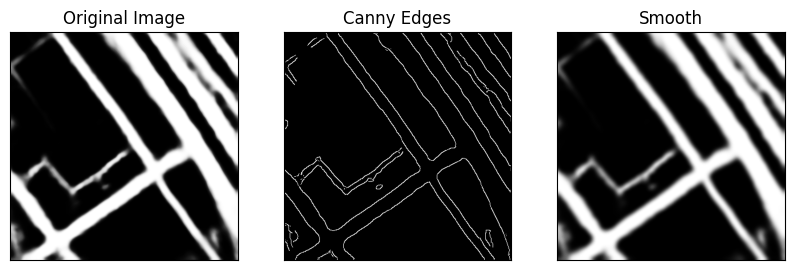

In [372]:
img = denormalized_image
edges = cv2.Canny(img, 100, 150)

blurred = cv2.GaussianBlur((preds_lst[0]* 255).astype(np.uint8), (9, 9), 5)
edges2 = cv2.Canny(blurred, 100, 200)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 2), plt.imshow(edges, cmap='gray')
plt.title('Canny Edges'), plt.xticks([]), plt.yticks([])

plt.subplot(1, 3, 3), plt.imshow(blurred, cmap='gray')
plt.title('Smooth'), plt.xticks([]), plt.yticks([])

In [375]:
blurred, (preds_lst[0]* 255).astype(np.uint8)

(array([[  1,   1,   1, ...,   4,   3,   3],
        [  1,   1,   1, ...,   4,   3,   3],
        [  1,   1,   1, ...,   4,   4,   4],
        ...,
        [ 47,  48,  49, ..., 113, 122, 125],
        [ 51,  51,  53, ..., 111, 120, 123],
        [ 52,  52,  54, ..., 110, 119, 122]], dtype=uint8),
 array([[[  2],
         [  1],
         [  1],
         ...,
         [  3],
         [  3],
         [  3]],
 
        [[  2],
         [  1],
         [  1],
         ...,
         [  3],
         [  3],
         [  3]],
 
        [[  1],
         [  1],
         [  1],
         ...,
         [  3],
         [  3],
         [  3]],
 
        ...,
 
        [[ 50],
         [ 52],
         [ 54],
         ...,
         [129],
         [144],
         [153]],
 
        [[ 60],
         [ 62],
         [ 64],
         ...,
         [124],
         [139],
         [147]],
 
        [[ 67],
         [ 69],
         [ 71],
         ...,
         [118],
         [133],
         [138]]], dtype=uint

In [351]:
edges2

array([[255,   0,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0],
       [255, 255,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [228]:
morphed = []
for i in range(len(preds_lst)):
    morphed.append(apply_morphological_operations(preds_lst[i], size=(3,3)))
morphed = np.array(morphed)

In [376]:
#plot_samples(imgs_lst, preds_lst, gt_list, morphed)

In [388]:
patched_gt = np.round(np.mean(np.moveaxis(gt_list.reshape((-1, 400 // 16, 16, 400 // 16, 16)), 2,3), (-1, -2)) >0.25)
patched_preds = np.round(np.mean(np.moveaxis(preds_lst.reshape((-1, 400 // 16, 16, 400 // 16, 16)), 2,3), (-1, -2)) >0.25)

In [389]:
postprocessed_patches = np.empty_like(patched_preds)

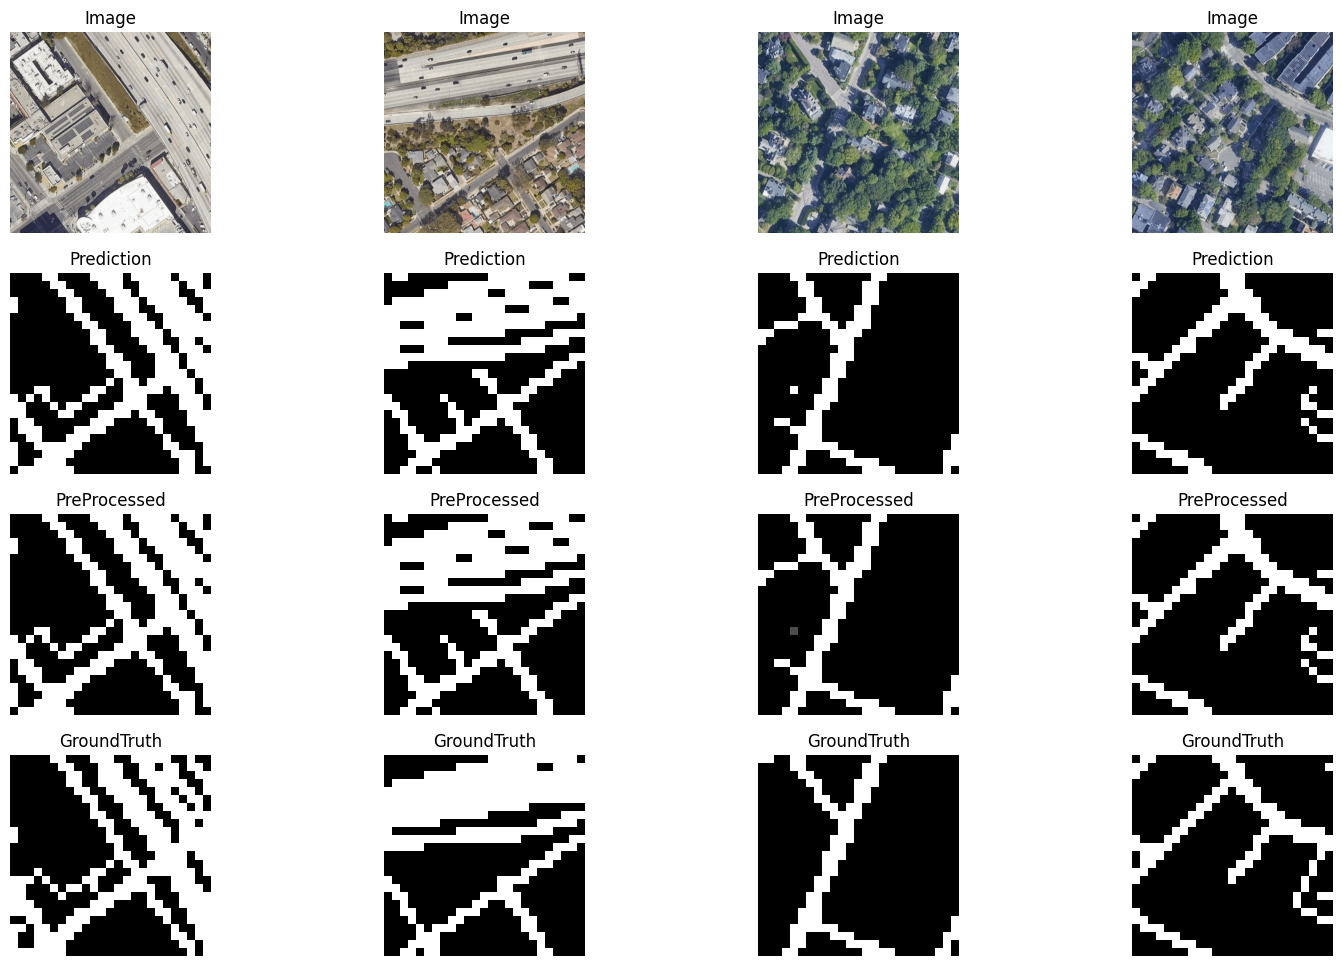

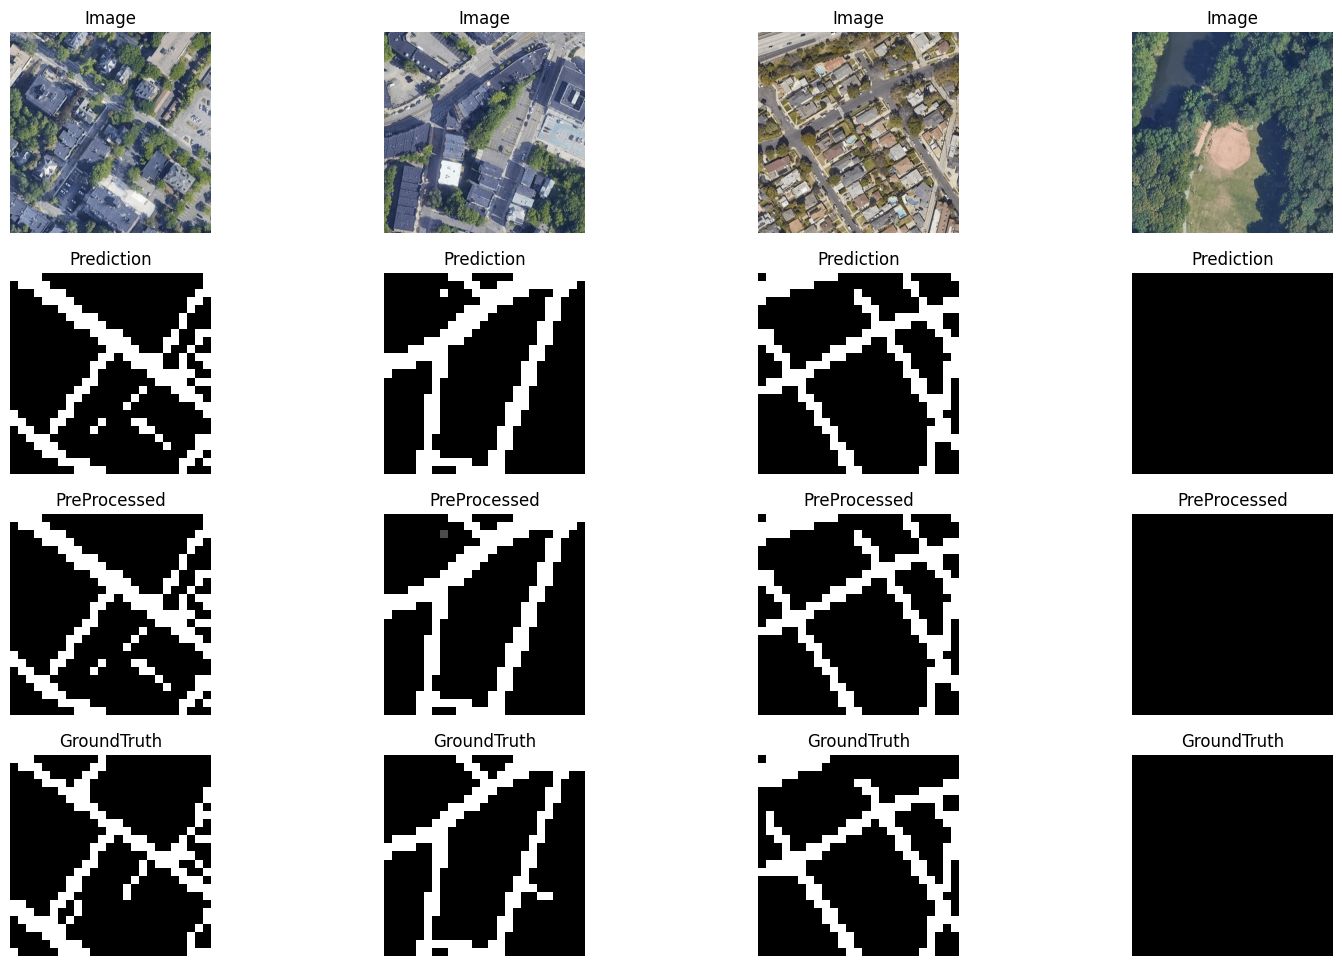

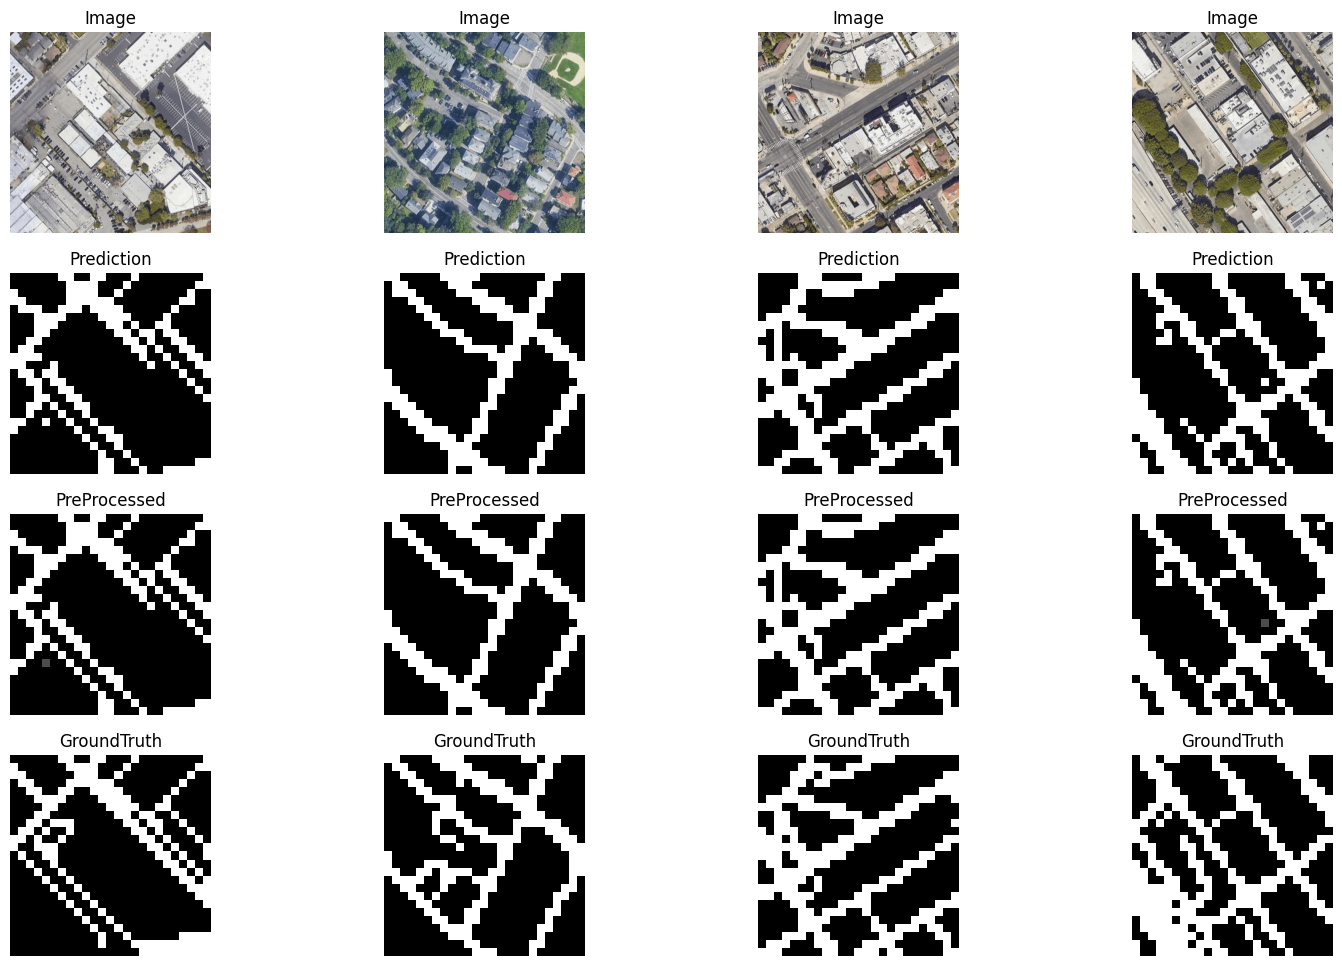

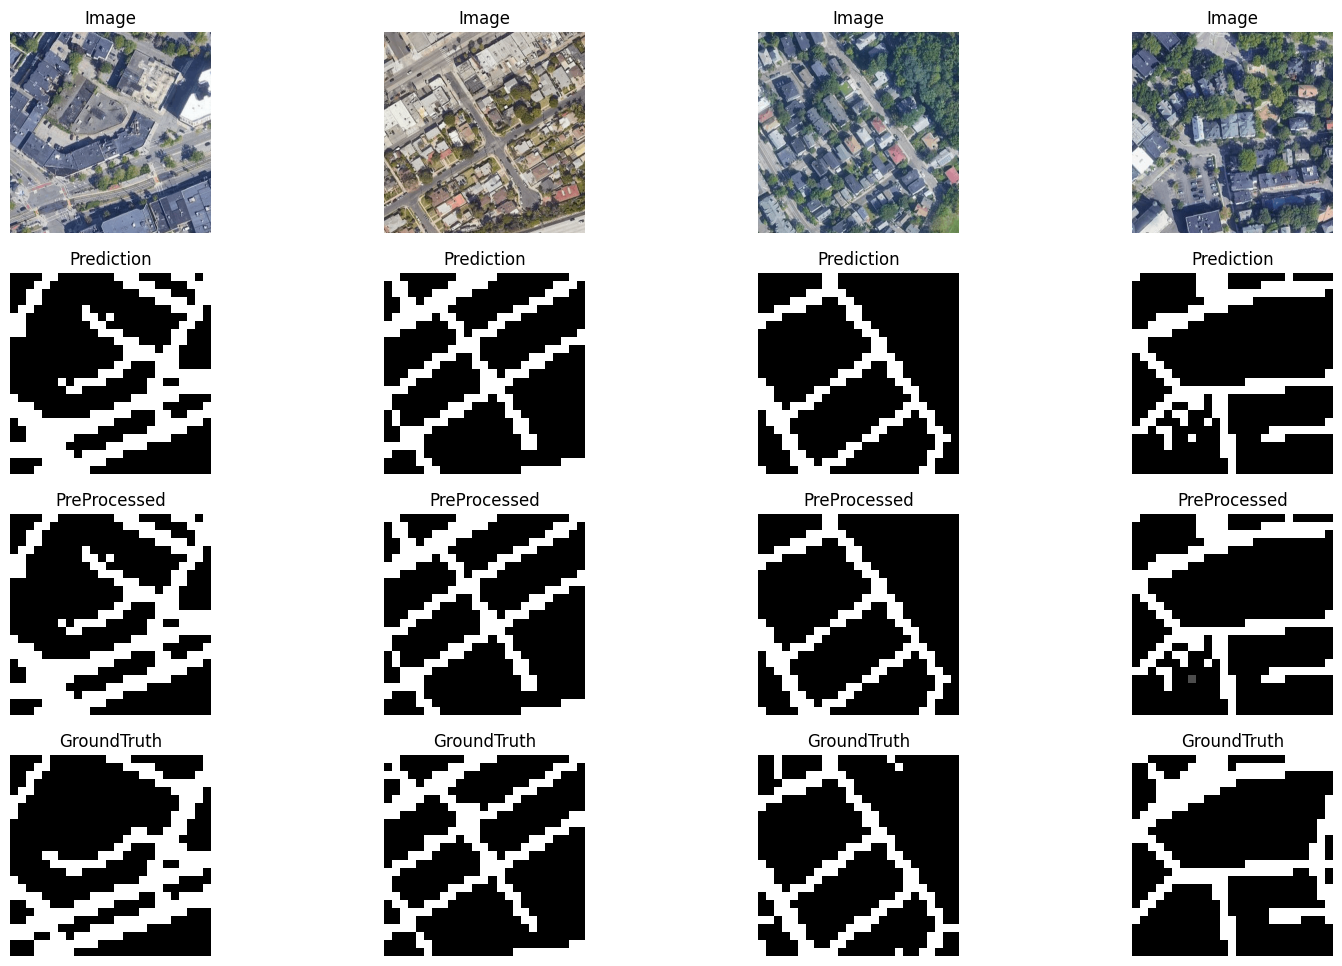

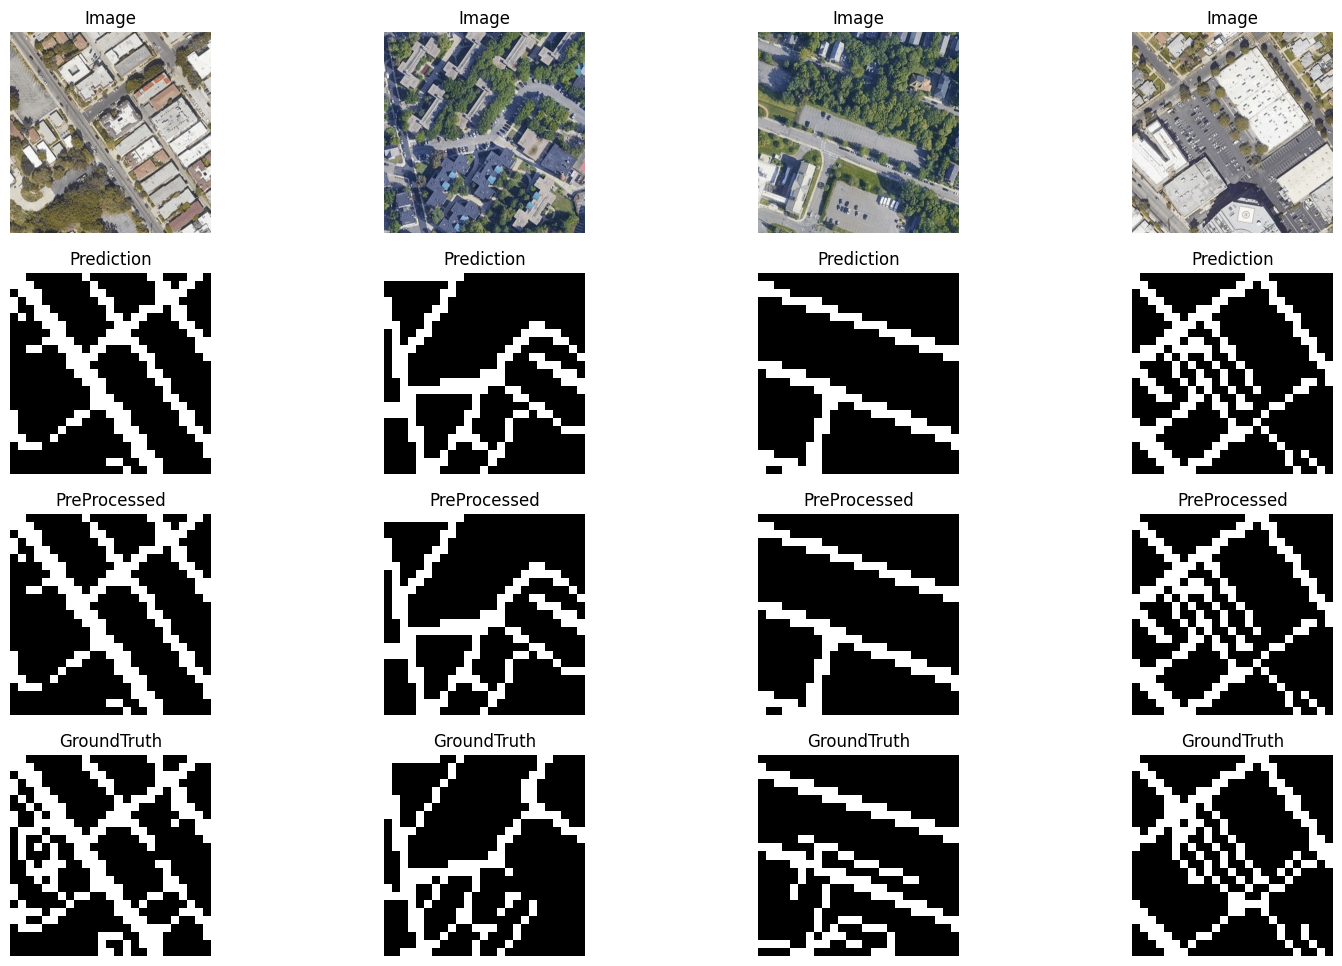

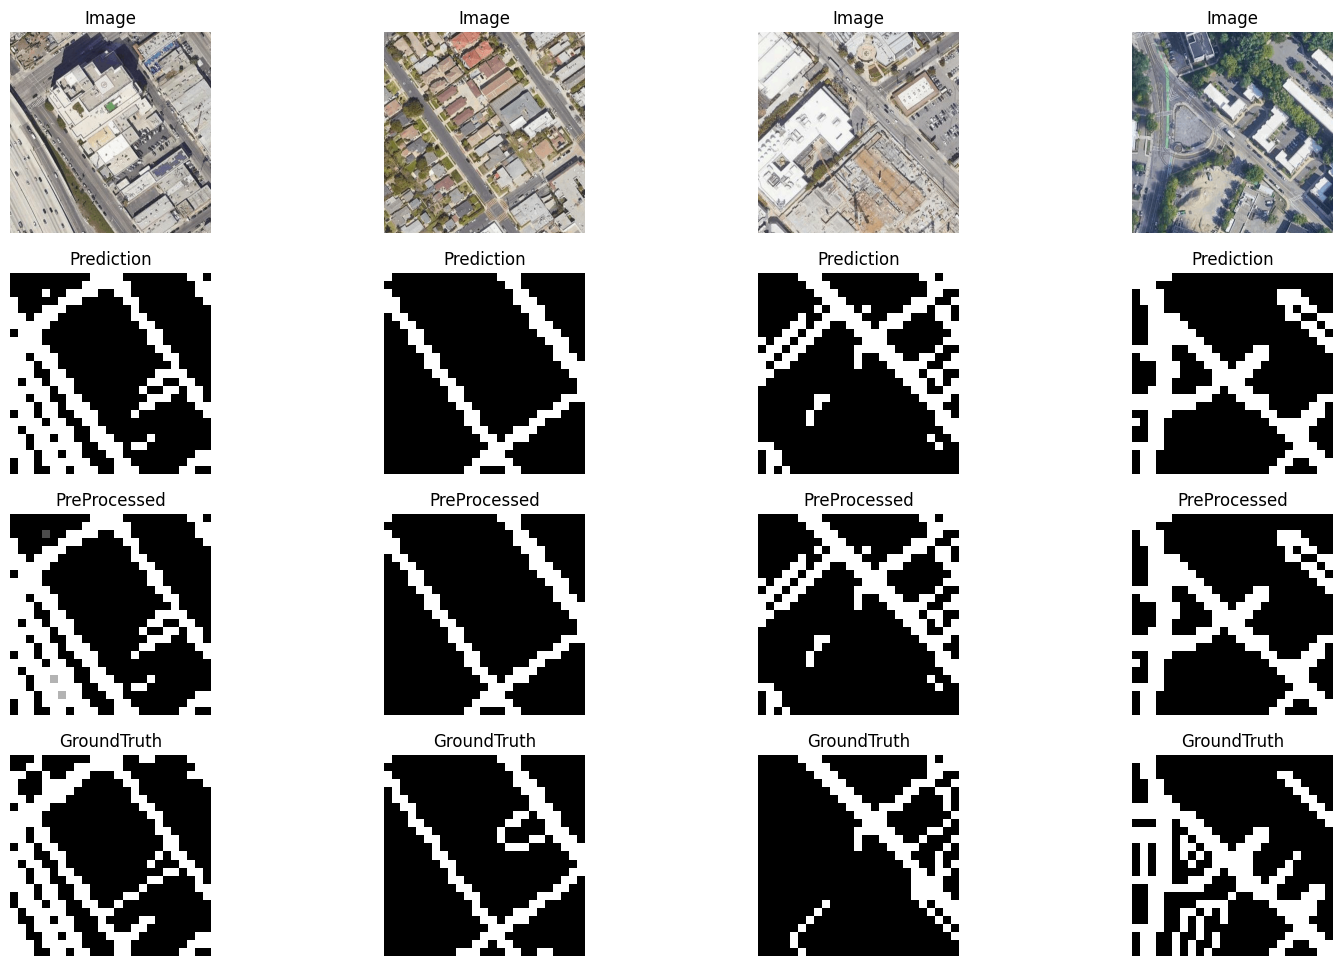

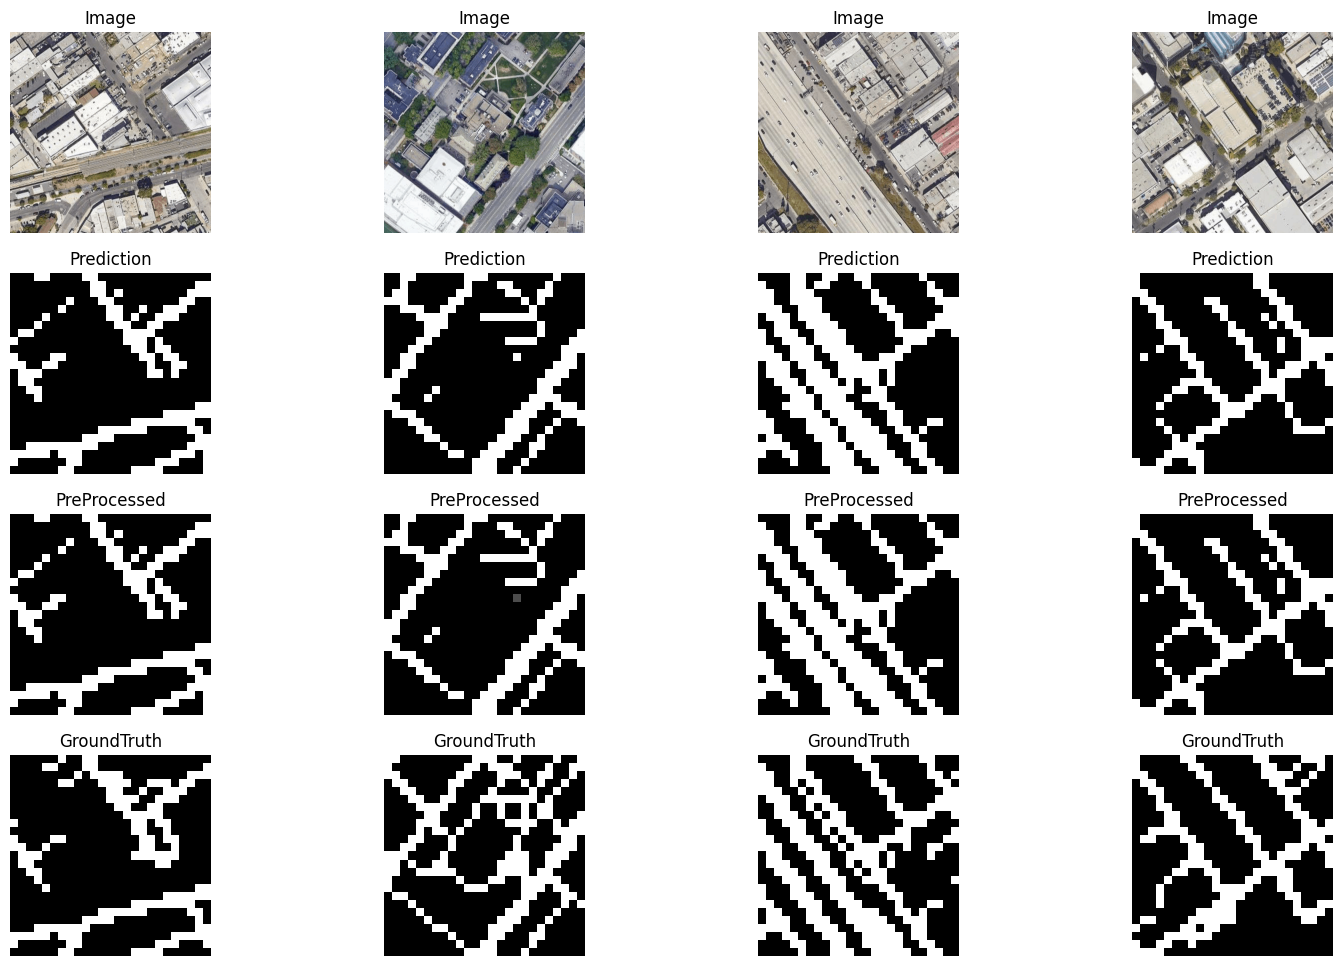

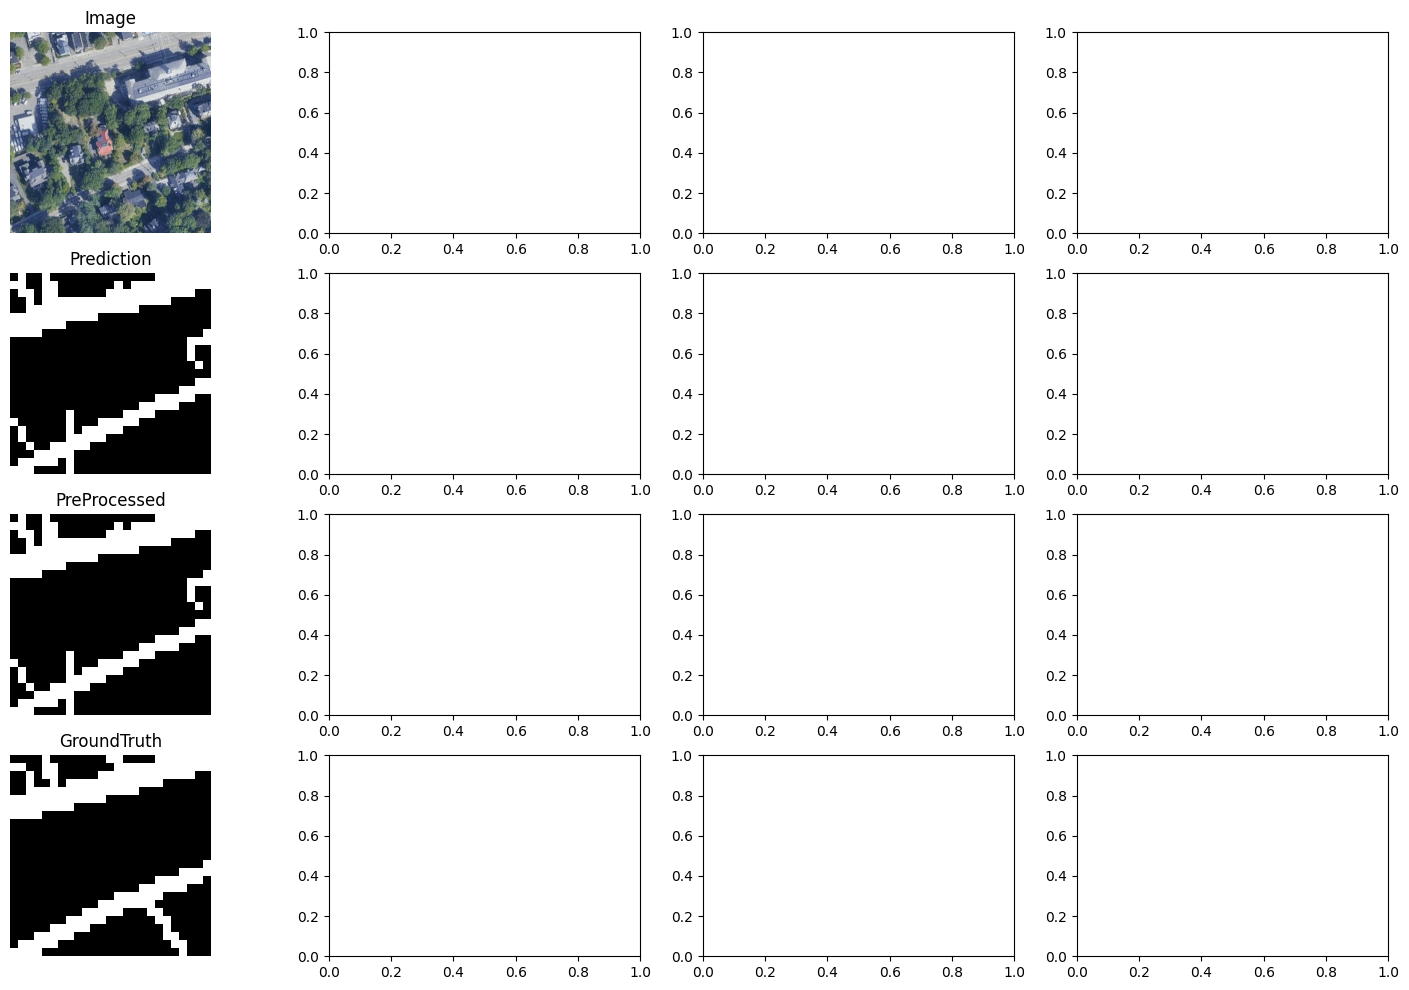

In [391]:
plot_samples(imgs_lst, patched_preds, patched_gt, postprocessed_patches)

In [306]:
def compute_true_count(i, k, l, patched_preds):
    curr_patch = patched_preds[i][k][l]
    top = bot = left = right = 0
    tl = tr = bl = br = 0
    top = patched_preds[i][k-1][l]
    bot = patched_preds[i][k+1][l]
    left = patched_preds[i][k][l-1]
    right = patched_preds[i][k][l+1]
    tl = patched_preds[i][k-1][l-1]
    tr = patched_preds[i][k-1][l+1]
    bl = patched_preds[i][k+1][l-1]
    br = patched_preds[i][k+1][l+1]
    variables = [top, bot, left, right, tl, tr, br, bl]
    true_count = sum(variables)
    return true_count

In [411]:
setting_1 = 0
setting_0 = 0
for i in range(len(patched_preds)):
    for k in range(25):
        for l in range(25):
            if k > 1 and k < 23 and l > 1 and l < 23:
                true_count = compute_true_count(i, k, l, patched_preds)

                if patched_preds[i][k][l] == 0:
                    postprocessed_patches[i][k][l] = patched_preds[i][k][l]
                else:
                    if true_count == 0:
                        setting_0 += 1
                        print(f"Removed one for picture {i}")
                        postprocessed_patches[i][k][l] = 0.3
                    else:
                        postprocessed_patches[i][k][l] = patched_preds[i][k][l]
            else:
                postprocessed_patches[i][k][l] = patched_preds[i][k][l]
setting_1, setting_0

Removed one for picture 2
Removed one for picture 5
Removed one for picture 8
Removed one for picture 11
Removed one for picture 15
Removed one for picture 20
Removed one for picture 25


(0, 7)

In [408]:
postprocessed_patches = (postprocessed_patches > 0.5).astype(int)

In [409]:
tp, fp, fn, tn = smp.metrics.get_stats(torch.from_numpy(postprocessed_patches).long(), torch.from_numpy(patched_gt).long(), mode="binary", threshold=0.1)

In [410]:
smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

tensor(0.8289)

In [169]:
def best_threshold(model, test_dataset, batch_size, threshold=0.5):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True,
    )
    model.eval()
    accuracy = []
    f1score = []
    iou = []
    with torch.no_grad():
        for images, true_masks, _ in tqdm(test_loader):
            true_list = []
            predictions_list = []
            images = images.to(device)
            probabilities = model.predict(images)
            predicted_masks = torch.sigmoid(probabilities).permute(0, 2, 3, 1).cpu().numpy()
            predicted_masks = (predicted_masks > threshold).astype(np.uint8)
            crop = A.Compose([
                A.CenterCrop(height=400, width=400),
            ])
            true_masks = true_masks.permute(0, 2, 3, 1).cpu().numpy()
            for true_mask, mask in zip(true_masks, predicted_masks):
                cropped = crop(image=true_mask, mask=mask)
                true_mask = cropped["image"]
                pred_mask = cropped["mask"]
                true_mask = patch(true_mask)
                pred_mask = patch(pred_mask)
                true_list.append(true_mask)
                predictions_list.append(pred_mask)
            trues = np.asarray(true_list)
            trues = trues.reshape(trues.shape[0], 1, trues.shape[1], trues.shape[2])
            trues = torch.from_numpy(trues)
            preds = np.asarray(predictions_list)
            preds = preds.reshape(preds.shape[0], 1, preds.shape[1], preds.shape[2])
            preds = torch.from_numpy(preds)

            tp, fp, fn, tn = smp.metrics.get_stats(preds / 255, trues // 255, mode="binary", threshold=0.1)
            accuracy.append(smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro"))
            f1score.append(smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro"))
            iou.append(smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro"))

    return np.mean(accuracy), np.mean(f1score), np.mean(iou)

In [159]:
def patch(im_arr):
    im_arr = (im_arr.reshape(400, 400) * 255.0).astype(np.uint8)
    patch_size = 16
    mask = np.zeros_like(im_arr)
    for j in range(0, im_arr.shape[1], patch_size):
        for i in range(0, im_arr.shape[0], patch_size):
            patch = im_arr[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            mask[i:i + patch_size, j:j + patch_size] = int(label * 255)
    return mask


In [162]:
def patch_to_label(patch):
    patch = patch.astype(np.float64) / 255
    df = np.mean(patch)
    if df > 0.25:
        return 1
    else:
        return 0


100%|█████████████████████████████████████████████| 8/8 [01:07<00:00,  8.47s/it]


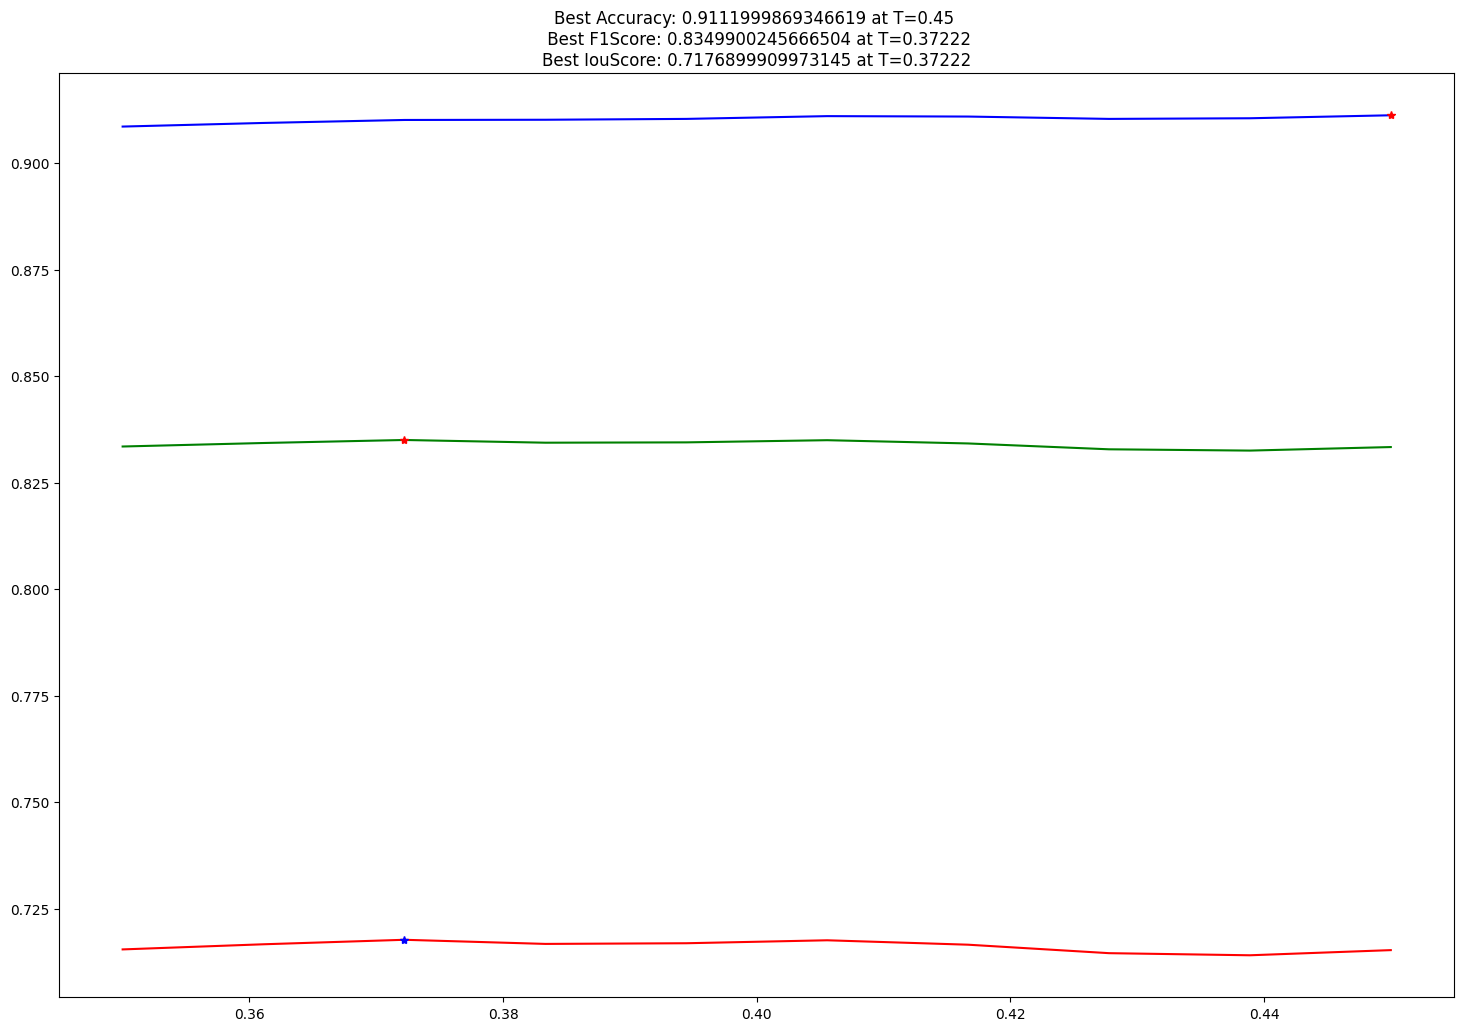

In [245]:
def log_threshold(best_model, valid_dataset, resolution=10):
    thresholds = np.linspace(0.35, 0.45, resolution)
    accuracy_list = []
    f1score_list = []
    iou_list = []
    for threshhold in thresholds:
        accuracy, f1score, iou = best_threshold(best_model, valid_dataset, batch_size=4, threshold=threshhold)
        accuracy_list.append(accuracy)
        f1score_list.append(f1score)
        iou_list.append(iou)
    fig = plt.figure(figsize=(18, 12))
    plt.plot(thresholds, accuracy_list, "-b")
    plt.plot(thresholds, f1score_list, "-g")
    plt.plot(thresholds, iou_list, "-r")
    plt.plot(thresholds[np.argmax(accuracy_list)], accuracy_list[np.argmax(accuracy_list)], marker="*", color="r")
    plt.plot(thresholds[np.argmax(f1score_list)], f1score_list[np.argmax(f1score_list)], marker="*", color="r")
    plt.plot(thresholds[np.argmax(iou_list)], iou_list[np.argmax(iou_list)], marker="*", color="b")

    plt.title(
        F"Best Accuracy: {np.round(accuracy_list[np.argmax(accuracy_list)], 5)} at T={np.round(thresholds[np.argmax(accuracy_list)], 5)} \n "
        F"Best F1Score: {np.round(f1score_list[np.argmax(f1score_list)], 5)} at T={np.round(thresholds[np.argmax(f1score_list)], 5)}\n"
        F"Best IouScore: {np.round(iou_list[np.argmax(iou_list)], 5)} at T={np.round(thresholds[np.argmax(iou_list)], 5)}")
log_threshold(model, valid_dataset)